# SPAM message classifier

This task is based on the spam message dataset provided at http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ . "The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam."  

The data is being used to train a couple of our models as well check the accuracy of prediction. Then we this model will be integrated into our simple web application where you can input a text string get prediction results, if the message is indeed a spam.

## 1. Import and manipulate/check data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load data from csv file
data = pd.read_csv("./data/spam.csv",encoding='latin-1')

In [3]:
data.shape

(5572, 5)

In [4]:
data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# select and rename the columns relevant to us 
data = data[['v2','v1']]
data = data.rename(columns={"v1":"label", "v2":"text"})

print(data.groupby('label').size())

label
ham     4825
spam     747
dtype: int64


In [6]:
data.isnull().values.any()

False

In [7]:
# convert the output data/ label to binary value
data['label'] = data.label.replace(to_replace=['ham', 'spam'], value=[0, 1])

In [8]:
data.head(5)

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


## 2. Visualization of data

We used a visualization example for wordcloud to get an overview of the words present in the spam and legitimate messages

### 2.1 Message length distribution per category

C:\Users\Bipin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Bipin\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


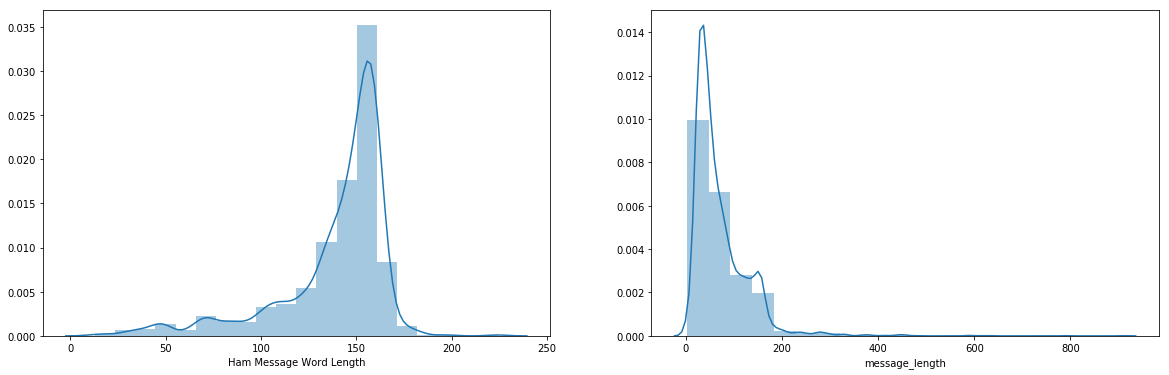

In [9]:
plotdata = data
plotdata["message_length"] = data["text"].apply(len)

f, ax = plt.subplots(1, 2, figsize = (20, 6))


sns.distplot(plotdata[plotdata["label"] == 1]["message_length"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(plotdata[plotdata["label"]== 0]["message_length"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

### 2.2 Word Cloud Data Visualization

In [10]:
ham_words = ''
spam_words = ''
spam = data[data.label == 1]
ham = data[data.label ==0]

In [11]:
import nltk

In [12]:
for val in spam.text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for val in ham.text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [13]:
from wordcloud import WordCloud

In [14]:
spam_wordcloud = WordCloud(width=600, height=400).generate(spam_words)
ham_wordcloud = WordCloud(width=600, height=400).generate(ham_words)

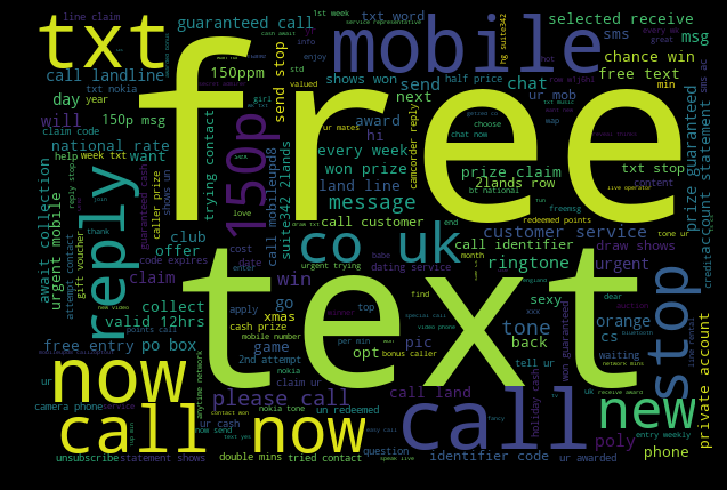

In [15]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

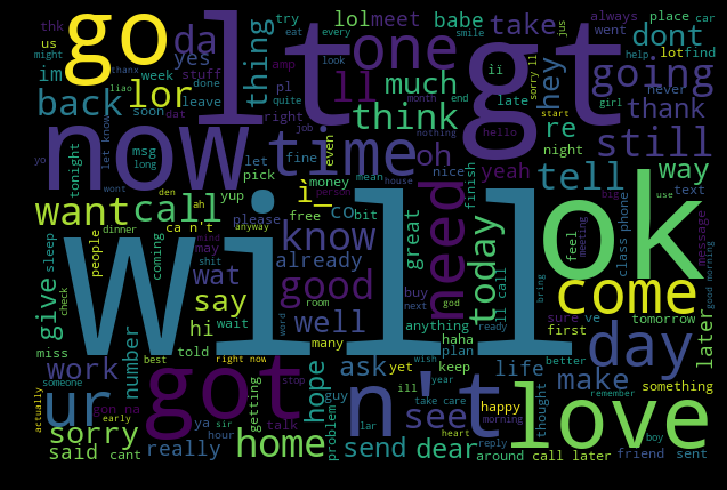

In [16]:
#legitimate/ham word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## 3. Stemming the text messages

We are using the nltk module to create corpus (removing special characters and punctuation) from the text messages and convert the text to lowercase. Then the stopwords (most common words) are filtered out and stemming (converting words to thier stem/base word) is performed. The stemming makes the text dense and reduces the size of dictionary and takes different variations of words as one. This might sometimes reduces the accuracy of prediction due to different meaing between the form of words.

In [17]:
import re
import os
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [18]:
portstemmer = PorterStemmer()
stop = stopwords.words('english')
corpus = []
for i in range (0,len(data)):
    mess = re.sub('[^a-zA-Z]',repl = ' ',string = data['text'][i])
    mess.lower()
    mess = mess.split()
    mess = [portstemmer.stem(word) for word in mess if word not in set(stop)]
    mess = ' '.join(mess)
    corpus.append(mess)

In [19]:
corpus[0]

'Go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

## 4. Create a sparse matrix by vectorizing words

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [21]:
X, y = vectorizer.fit_transform(corpus).toarray(), data['label'].values

In [22]:
X[1]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## 5. Split the data

In [23]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [24]:
print('Number of rows in the total set: {}'.format(data.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 5572
Number of rows in the training set: 3900
Number of rows in the test set: 1672


## 6. Bayes with MultinomialNB

In [25]:
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [26]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print(predictions)

[0 0 0 ... 0 0 0]


In [27]:
# Validate the accuracy of the predictions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.9766746411483254
Precision score:  0.8874458874458875
Recall score:  0.9403669724770642
F1 score:  0.9131403118040089


We observed the predictions to be quite accurate even when the dataset was split into halves for train and test. 

### 6.1 Confusion matrix

Text(0.5,15,'Predicted label')

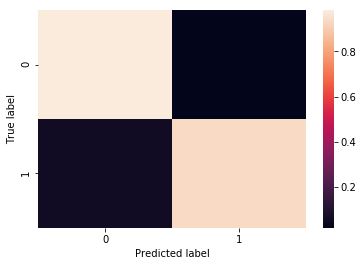

In [28]:
conf_mat = confusion_matrix(y_test, predictions)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### 6.2 Using the model in new set of data

In [29]:
data_new = pd.read_csv("./data/spam_source_2.csv",encoding='latin-1')

In [30]:
data_new.head(5)

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or Â£10,000..."
4,spam,okmail: Dear Dave this is your final notice to...


In [31]:
# select and rename the columns relevant to us 
data_new = data_new.rename(columns={"type":"label"})

print(data_new.groupby('label').size())

label
ham     4812
spam     747
dtype: int64


In [32]:
data_new.isnull().values.any()

False

In [33]:
data_new.head(5)

,label,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or Â£10,000..."
4,spam,okmail: Dear Dave this is your final notice to...


In [34]:
# convert the output data/ label to binary value
data_new['label'] = data_new.label.replace(to_replace=['ham', 'spam'], value=[0, 1])

In [35]:
corpus_new = []
for i in range (0,len(data_new)):
    mess_new = re.sub('[^a-zA-Z]',repl = ' ',string = data_new['text'][i])
    mess_new.lower()
    mess_new = mess_new.split()
    mess_new = [portstemmer.stem(word) for word in mess_new if word not in set(stop)]
    mess_new = ' '.join(mess_new)
    corpus_new.append(mess_new)

In [36]:
X_new, y_new = vectorizer.transform(corpus_new), data_new['label'].values

In [37]:
X_new.shape

(5559, 6304)

In [38]:
y_new.shape

(5559,)

In [39]:
predictions_new = classifier.predict(X_new)
print(predictions_new)

[0 0 0 ... 1 1 0]


In [40]:
# Validate the accuracy of the predictions
print('Accuracy score: ', format(accuracy_score(y_new, predictions_new)))
print('Precision score: ', format(precision_score(y_new, predictions_new)))
print('Recall score: ', format(recall_score(y_new, predictions_new)))
print('F1 score: ', format(f1_score(y_new, predictions_new)))

Accuracy score:  0.9883072495053067
Precision score:  0.94750656167979
Recall score:  0.9665327978580991
F1 score:  0.9569251159708415


We observed the model to perform good predictions on the spam dataset from different source

### 6.2 Save the model

In [41]:
import pickle

pickle.dump(classifier, open("bayes_classifier.pickle", "wb"))

pickle.dump(vectorizer, open("vector.pickle", "wb"))

pickle.dump(stop, open("stop.pickle", "wb"))


In [42]:
# test load the classifier
classifier = pickle.load(open('bayes_classifier.pickle', 'rb'))

vectorizer = pickle.load(open('vector.pickle', 'rb'))

stop = pickle.load(open('stop.pickle', 'rb'))

predictions = classifier.predict(X_test)
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))

Accuracy score:  0.9766746411483254


### Function to corpus a input message

In [43]:
def corpus_message(text):
    mess = re.sub('[^a-zA-Z]',repl = ' ',string = text)
    mess.lower()
    mess = mess.split()
    mess = [portstemmer.stem(word) for word in mess if word not in set(stop)]
    mess = ' '.join(mess)
    mess_array=  np.array([mess])
    print(mess_array[0])
    return mess_array

### Custom text test

In [44]:
test_string = 'text for free prize'
test_corpus = corpus_message(test_string)
test_vector = vectorizer.transform(test_corpus)
test_vector

text free prize


<1x6304 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [45]:
predictions = classifier.predict(test_vector)
predictions

array([1], dtype=int64)

## 7. Ensemble Random Forest classifier

In [46]:
# create and train the model

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
predictions = model.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
# Validate the accuracy of the predictions
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Accuracy score:  0.97188995215311
Precision score:  1.0
Recall score:  0.7844036697247706
F1 score:  0.8791773778920309


Text(0.5,15,'Predicted label')

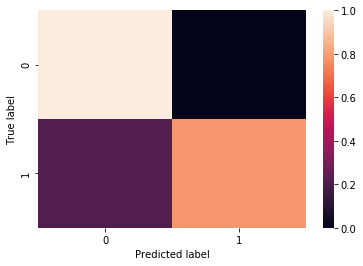

In [49]:
conf_mat = confusion_matrix(y_test, predictions)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

## 8. Web App

In [50]:
%%writefile mywebapp.py

from flask import Flask, render_template, request
from wtforms import Form, TextAreaField, validators
import pickle
import os
import re
import numpy as np
from nltk.stem.porter import PorterStemmer


portstemmer = PorterStemmer()


# loading the serialized classifier, vectorizer and stopwords
classifier = pickle.load(open('bayes_classifier.pickle', 'rb'))

vectorizer = pickle.load(open('vector.pickle', 'rb'))

stop = pickle.load(open('stop.pickle', 'rb'))


def corpus_message(text):
    mess = re.sub('[^a-zA-Z]',repl = ' ',string = text)
    mess.lower()
    mess = mess.split()
    mess = [portstemmer.stem(word) for word in mess if word not in set(stop)]
    mess = ' '.join(mess)
    mess_array=  np.array([mess])
    return mess_array

def classify(message):
    label = {0: 'ham', 1: 'spam'}
    document = corpus_message(message)
    X = vectorizer.transform(document)
    y = classifier.predict(X)[0]
    proba = np.max(classifier.predict_proba(X))
    return label[y], proba



# create an instance (our app)
app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])
def index():
    form = None
    if request.method == 'POST' and 'spam' in request.form:
        form = request.form['spam']
    return render_template('default.html', form=form)


@app.route('/results', methods=['POST'])
def results():
    form = request.form
    if request.method == 'POST':
        message = request.form['spam']
        y, proba = classify(message)
        return render_template('results.html',
                                content=message,
                                prediction=y,
                                probability=round(proba*100, 2))
    return render_template('results.html', name=name)

if __name__ == '__main__':
    app.run(port=5000,debug=True);


Overwriting mywebapp.py


In [ ]:
!python mywebapp.py

## 9. Conclusion

The predictions generated from both the models were quite remarkable on both the test and externald dataset. However, the dataset was not overly complex to warrant huge failures in predictions. Finally, we are happy with the results obtained.

## 10 Web App preview

![](images/1.png)

![](images/2.png)  

![](images/3.png)

![](images/4.png)